In [1]:
from differences import ATTgt, TWFE
from matplotlib import pyplot as plt
plt.rcParams["figure.dpi"] = 300
plt.rcParams['savefig.dpi'] = 300
from panel_utilities import get_value_variable_names, prepare_df_for_DiD
from stats_utilities import select_controls, test_balance, produce_summary_statistics
from figure_utilities import aggregate_by_event_time_and_plot, aggregate_by_time_and_plot
import pandas as pd



# Store paths.
analysis='group_0_crimes_500m'
INPUT_DATA = "../../data/03_cleaned/crime_analysis_monthly.parquet"
OUTPUT_FIGURES = f"../../output/{analysis}/figures"
OUTPUT_TABLES = f"../../output/{analysis}/tables"


# Read restricted sample panel dataset into memory.
df = pd.read_parquet(INPUT_DATA)



In [2]:
treatment_date_variable = 'latest_docket_month'
df = df.dropna(subset=treatment_date_variable)

# Generate value vars list and month to int dictionaries.
weekly_value_vars_crime, month_to_int_dictionary, int_to_month_dictionary = get_value_variable_names(df, analysis)

In [3]:
covariates_exploration_df = select_controls(df=df, analysis=analysis,
                                            treatment_date_variable=treatment_date_variable,
                                            output_directory=OUTPUT_TABLES)
covariates_exploration_df

Dependent Variable  \
                                                                                             Change in Crime Incidents, April 2019-March 2020   
                                                 \emph{Independent Variable}                                                                    
Panel A: Pre-treatment Outcomes                  total_twenty_seventeen_group_0_crimes_500m                                      9.889110e-33   
                                                 pre_treatment_change_in_group_0_crimes_500m                                    4.955083e-155   
Panel B: Census Tract Characteristics            frac_coll_plus2010                                                              7.546667e-01   
                                                 job_density_2013                                                                2.447371e-14   
                                                 med_hhinc2016                                                                   7.509563e-03   
                                                 poor_share2010                                                                  2.262321e-06   
                                                 popdensity2010                                                                  2.202862e-13   
Panel C: Case Initiation                         for_cause                                                                       1.222720e-01   
                                                 no_cause                                                                        8.041671e-01   
                                                 non_payment                                                                     1.305035e-02   
Panel D: Defendant and Plaintiff Characteristics hasAttyD                                                                        5.019711e-01   
                                                 hasAttyP                                                                        2.093000e-01   
                                                 isEntityD                                                                       1.266763e-01   
                                                 isEntityP                                                                       5.329954e-03   

                                                                                                               
                                                                                             Treated Property  
                                                 \emph{Independent Variable}                                   
Panel A: Pre-treatment Outcomes                  total_twenty_seventeen_group_0_crimes_500m      4.675480e-01  
                                                 pre_treatment_change_in_group_0_crimes_500m     4.594338e-01  
Panel B: Census Tract Characteristics            frac_coll_plus2010                              6.300067e-01  
                                                 job_density_2013                                6.967381e-01  
                                                 med_hhinc2016                                   2.713150e-02  
                                                 poor_share2010                                  3.442531e-03  
                                                 popdensity2010                                  8.582592e-01  
Panel C: Case Initiation                         for_cause                                       4.074914e-03  
                                                 no_cause                                        2.626528e-02  
                                                 non_payment                                     4.274988e-07  
Panel D: Defendant and Plaintiff Characteristics hasAttyD                                        1.222082e-08  
                                                 hasAttyP                                

In [4]:
balance_table, pre_treatment_covariates = test_balance(df, analysis, covariates_exploration_df, OUTPUT_TABLES)
balance_table

\
                                             Cases Won by Plaintiff   
Panel A Total Crime Incidents, 2017                     1151.910995   
        Change in Crime Incidents, 2017-2019            -155.352880   
Panel B Job density, 2013                              16161.032515   
        Median household income, 2016                  47553.063874   
        Poverty rate, 2010                                 0.279638   
        Population density, 2010                       23320.185868   
Panel C Filing for nonpayment                              0.716230   
Panel D Plaintiff is entity                                0.808377   

                                             Difference in Cases Won by Defendant  \
                                                                       Unweighted   
Panel A Total Crime Incidents, 2017                                    -26.090482   
        Change in Crime Incidents, 2017-2019                            -8.082569   
Panel B Job density, 2013                                             -845.940269   
        Median household income, 2016                                 2781.213062   
        Poverty rate, 2010                                              -0.022478   
        Population density, 2010                                      -128.009157   
Panel C Filing for nonpayment                                           -0.107994   
Panel D Plaintiff is entity                                             -0.083794   

                                                                         \
                                                  \emph{p}     Weighted   
Panel A Total Crime Incidents, 2017           4.675480e-01   -41.497398   
        Change in Crime Incidents, 2017-2019  4.594338e-01     4.132121   
Panel B Job density, 2013                     6.967381e-01  -642.776343   
        Median household income, 2016         2.713150e-02 -1226.056857   
        Poverty rate, 2010                    3.442531e-03    -0.012112   
        Population density, 2010              8.582592e-01  -789.589743   
Panel C Filing for nonpayment                 4.274988e-07    -0.037387   
Panel D Plaintiff is entity                   4.277201e-06    -0.037388   

                                                        
                                              \emph{p}  
Panel A Total Crime Incidents, 2017           0.251211  
        Change in Crime Incidents, 2017-2019  0.702286  
Panel B Job density, 2013                     0.769310  
        Median household income, 2016         0.240425  
        Poverty rate, 2010                    0.107445  
        Population density, 2010              0.268829  
Panel C Filing for nonpayment                 0.030793  
Panel D Plaintiff is entity                   0.022104

In [5]:
# Generate indicators for missing data.

# missing_indicators = add_missing_indicators(df, ['rent_twobed2015'], pre_treatment_covariates)

# Prepare df for use with the differences package.
df = df.reset_index()
df = prepare_df_for_DiD(df=df,
                        analysis=analysis,
                        treatment_date_variable=treatment_date_variable,
                        pre_treatment_covariates=pre_treatment_covariates,
                        missing_indicators=[],
                        value_vars=weekly_value_vars_crime,
                        period_to_int_dictionary=month_to_int_dictionary)

In [6]:
# Run DiD without conditioning on covariates.
att_gt = ATTgt(data=df, cohort_name=treatment_date_variable, freq='2W', base_period='universal')
result = att_gt.fit(formula=analysis, control_group='never_treated', n_jobs=-1)

Computing ATTgt [workers=10]  100%|████████████████████| 1104/1104 [00:11<00:00, 98.38it/s] 


-3.936128747863611
-2.6181861770824475
-2.4805317925971337
-0.5002095787544365


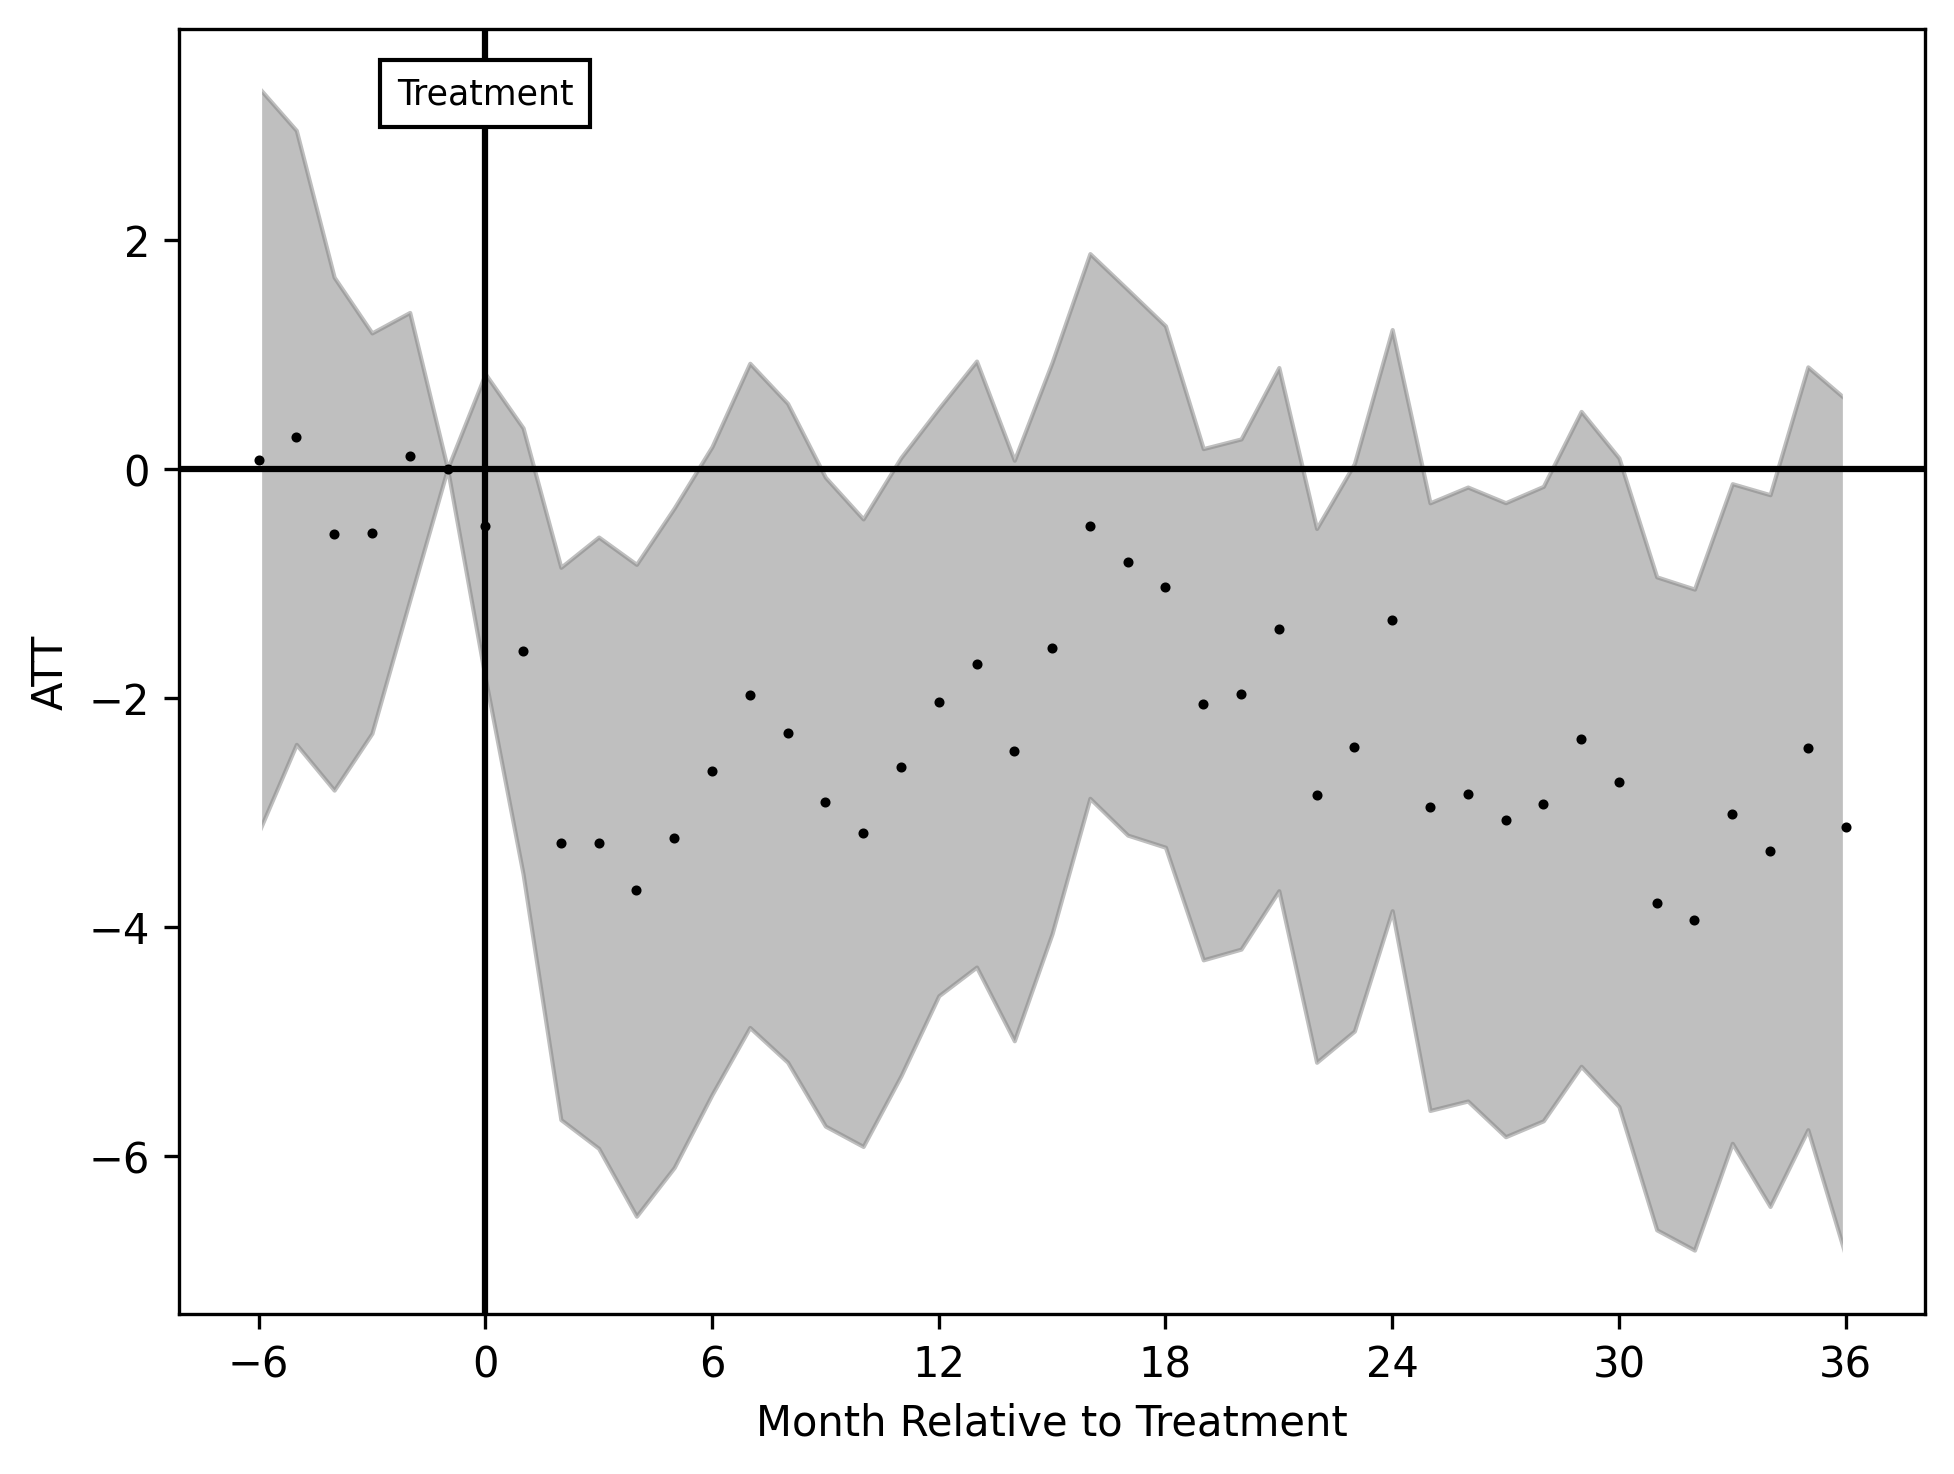

In [7]:
# Plot unconditional ATT(t-g)s on a long horizon.
aggregate_by_event_time_and_plot(att_gt, OUTPUT_FIGURES, "att_gt_unconditional_event_study_long_horizon.png",
                                 start_period=-6, end_period=36,
                                 title="",
                                 treatment_month_variable=treatment_date_variable, df=df)

In [8]:
# Run DiD conditional on covariates.
att_gt = ATTgt(data=df, cohort_name=treatment_date_variable, freq='M', base_period='universal')
formula = f'{analysis} ~ ' + '+'.join(pre_treatment_covariates)
result = att_gt.fit(formula=formula, control_group='never_treated', n_jobs=-1, progress_bar=True)

Computing ATTgt [workers=10]  100%|████████████████████| 1104/1104 [00:13<00:00, 84.76it/s] 


-4.943663927139639
-3.495976482648407
-3.48321828015306
-1.5383629754366348


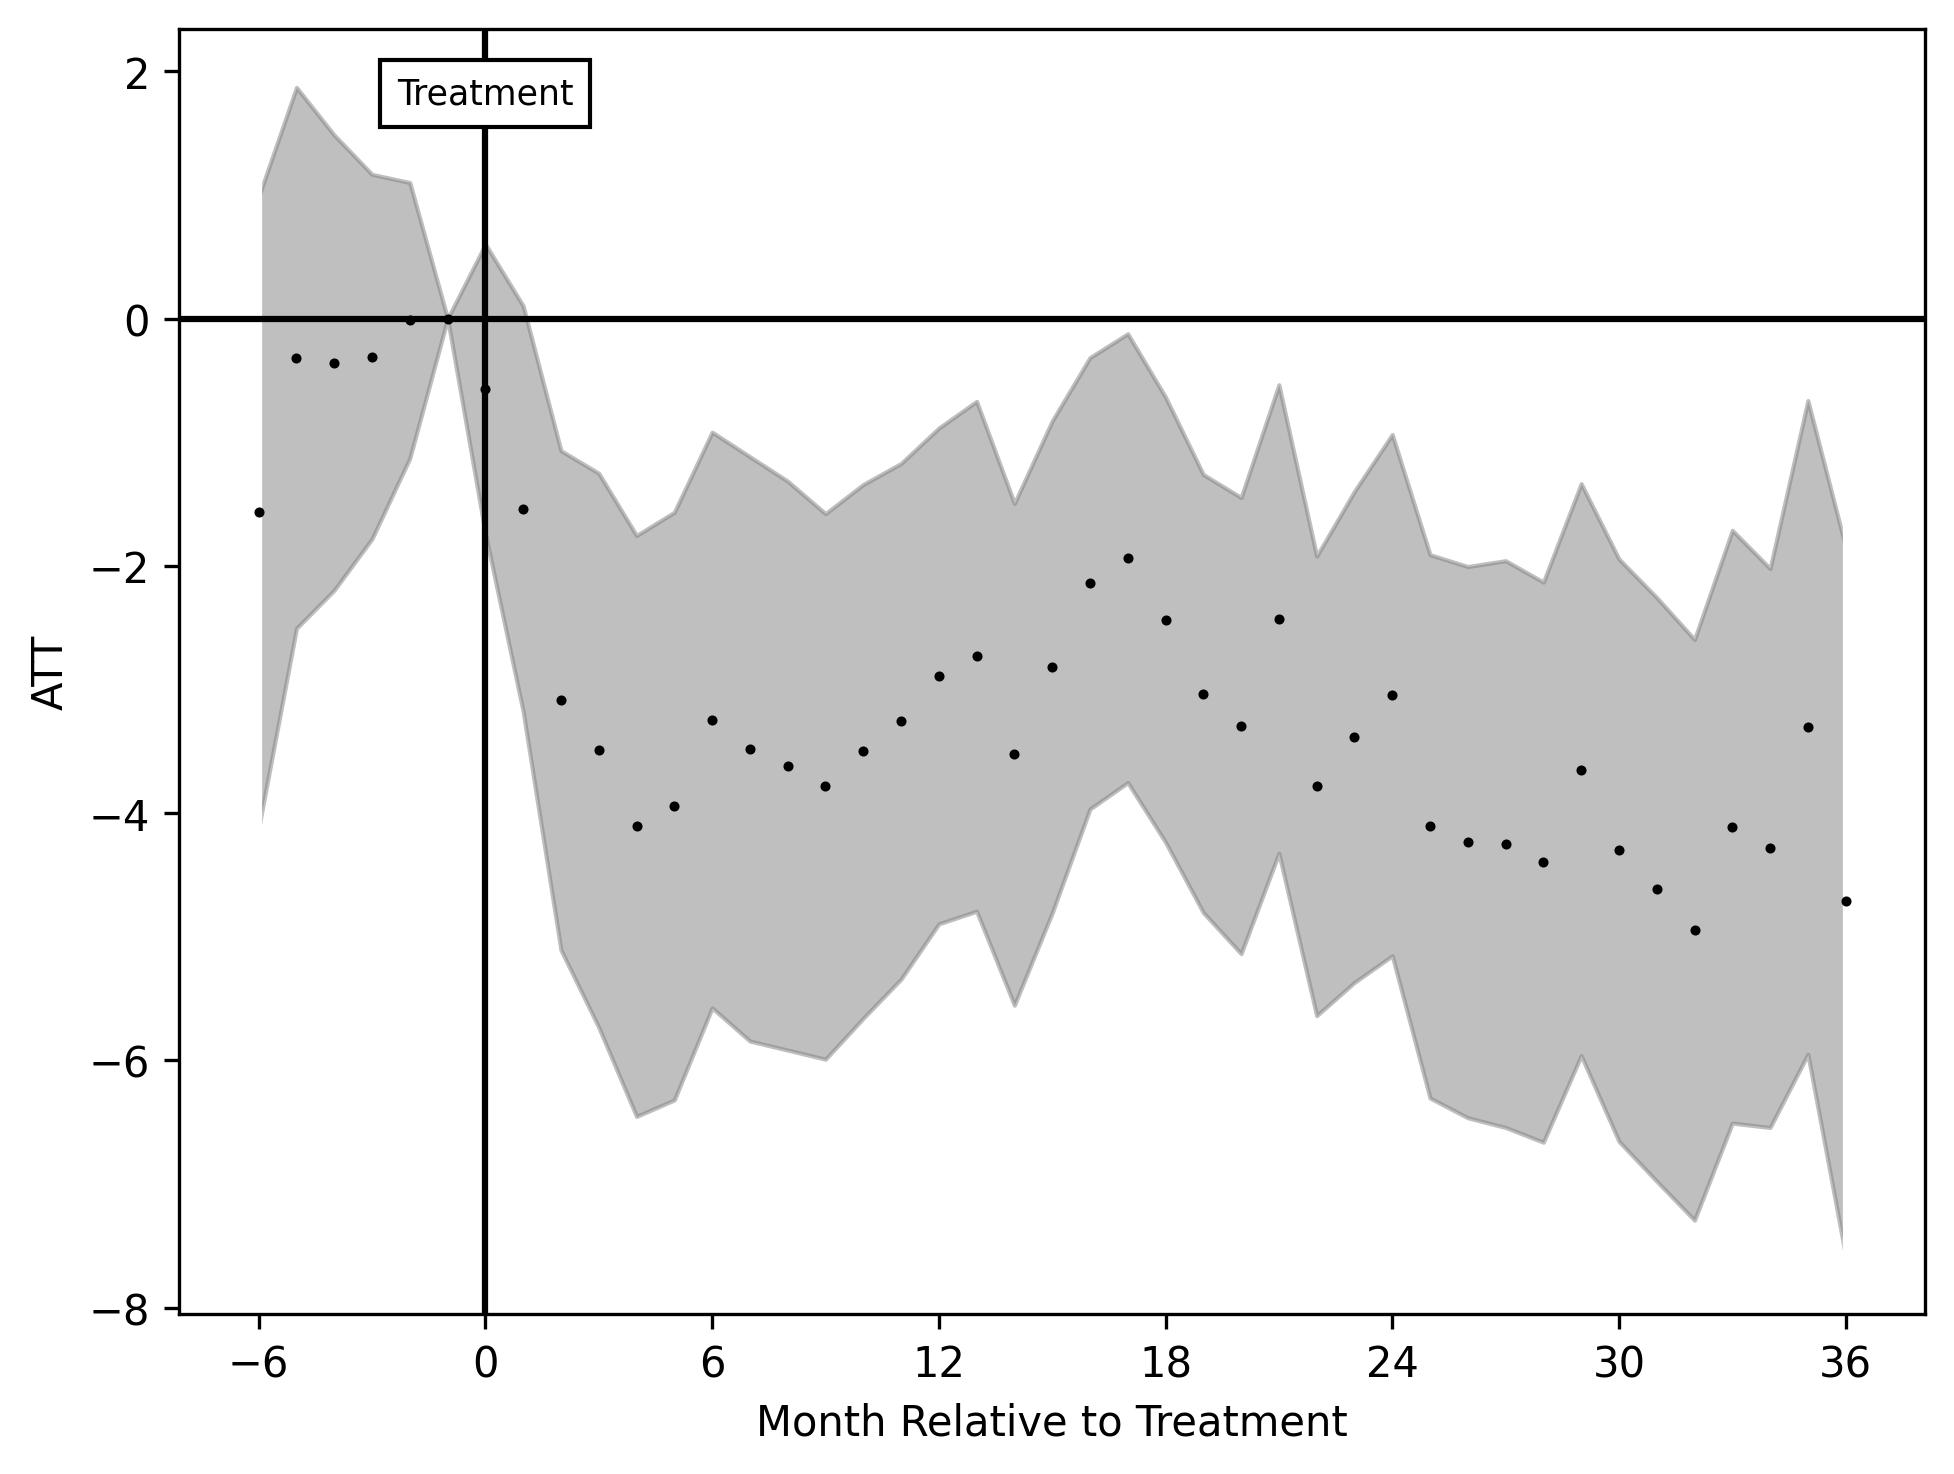

In [9]:
# Plot D.R. ATT(t-g)s on a long horizon.
aggregate_by_event_time_and_plot(att_gt, OUTPUT_FIGURES, "att_gt_dr_event_study_long_horizon.png", start_period=-6,
                                 end_period=36,
                                 title="",
                                 treatment_month_variable=treatment_date_variable, df=df)

In [10]:
twfe = TWFE(
    data=df,
    cohort_name=treatment_date_variable,
)

formula = f'{analysis} ~ ' + '+'.join(pre_treatment_covariates)
res = twfe.fit(
    formula=formula,
    cluster_names='case_number_numeric',
    drop_absorbed=True
)
print(res)


['isEntityP', 'job_density_2013', 'med_hhinc2016', 'non_payment', 'poor_share2010', 'popdensity2010', 'pre_treatment_change_in_group_0_crimes_500m', 'total_twenty_seventeen_group_0_crimes_500m'] dropped due to multicollinearity
           parameter  std_error      t_stat   p_value      lower      upper
Intercept  83.128947   0.736373  112.889746  0.000000  81.685683  84.572212
-57        -2.107045   3.475162   -0.606316  0.544305  -8.918237   4.704146
-56        -4.037437   2.696246   -1.497429  0.134282  -9.321983   1.247108
-55         0.373520   2.580394    0.144753  0.884906  -4.683960   5.431000
-54         0.961452   2.533833    0.379446  0.704357  -4.004771   5.927674
...              ...        ...         ...       ...        ...        ...
41          3.647698   2.919841    1.249280  0.211563  -2.075084   9.370481
42         -3.009791   4.511315   -0.667165  0.504667 -11.851806   5.832225
43          1.673514   6.200740    0.269889  0.787245 -10.479713  13.826741
44         2